<a href="https://colab.research.google.com/github/Lakshaykumarr28/Prasunet_Company_projects/blob/main/Prasunet_ML_05/food_Calorie_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Classification and Calorie Estimation

Create a model capable of accurately identifying food items within an image and predicting their corresponding calorie count to aid in maintaining a healthy and balanced diet.

Dataset used : http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz also available at https://www.kaggle.com/dansbecker/food-101

Importing essential libraries

In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.17.0
/device:GPU:0


Downloading the Dataset and unzipping it in Google Colab Environment

In [9]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")



Listing Food items directories

In [4]:
os.listdir('food-101/images')

['bruschetta',
 'fish_and_chips',
 'ceviche',
 'takoyaki',
 'spring_rolls',
 'cup_cakes',
 'peking_duck',
 'huevos_rancheros',
 'beignets',
 'fried_rice',
 'fried_calamari',
 'french_toast',
 'steak',
 'pho',
 'churros',
 'club_sandwich',
 'grilled_cheese_sandwich',
 'chicken_quesadilla',
 'waffles',
 'ramen',
 'ice_cream',
 'carrot_cake',
 'paella',
 'pancakes',
 'beef_carpaccio',
 'lasagna',
 'dumplings',
 'french_onion_soup',
 'sashimi',
 'french_fries',
 'panna_cotta',
 'pizza',
 'bibimbap',
 'frozen_yogurt',
 'spaghetti_bolognese',
 'cheese_plate',
 'chocolate_mousse',
 'mussels',
 'breakfast_burrito',
 'hamburger',
 'seaweed_salad',
 'ravioli',
 'poutine',
 'hummus',
 'nachos',
 'edamame',
 'chocolate_cake',
 'baby_back_ribs',
 'lobster_bisque',
 'crab_cakes',
 'beet_salad',
 'pork_chop',
 'spaghetti_carbonara',
 'lobster_roll_sandwich',
 'onion_rings',
 'prime_rib',
 'pulled_pork_sandwich',
 'tiramisu',
 'tuna_tartare',
 'caesar_salad',
 'foie_gras',
 'caprese_salad',
 'tacos',


Meta Files

In [5]:
os.listdir('food-101/meta')

['train.json',
 'labels.txt',
 'classes.txt',
 'train.txt',
 'test.json',
 'test.txt']

Plotting a random food item from each class

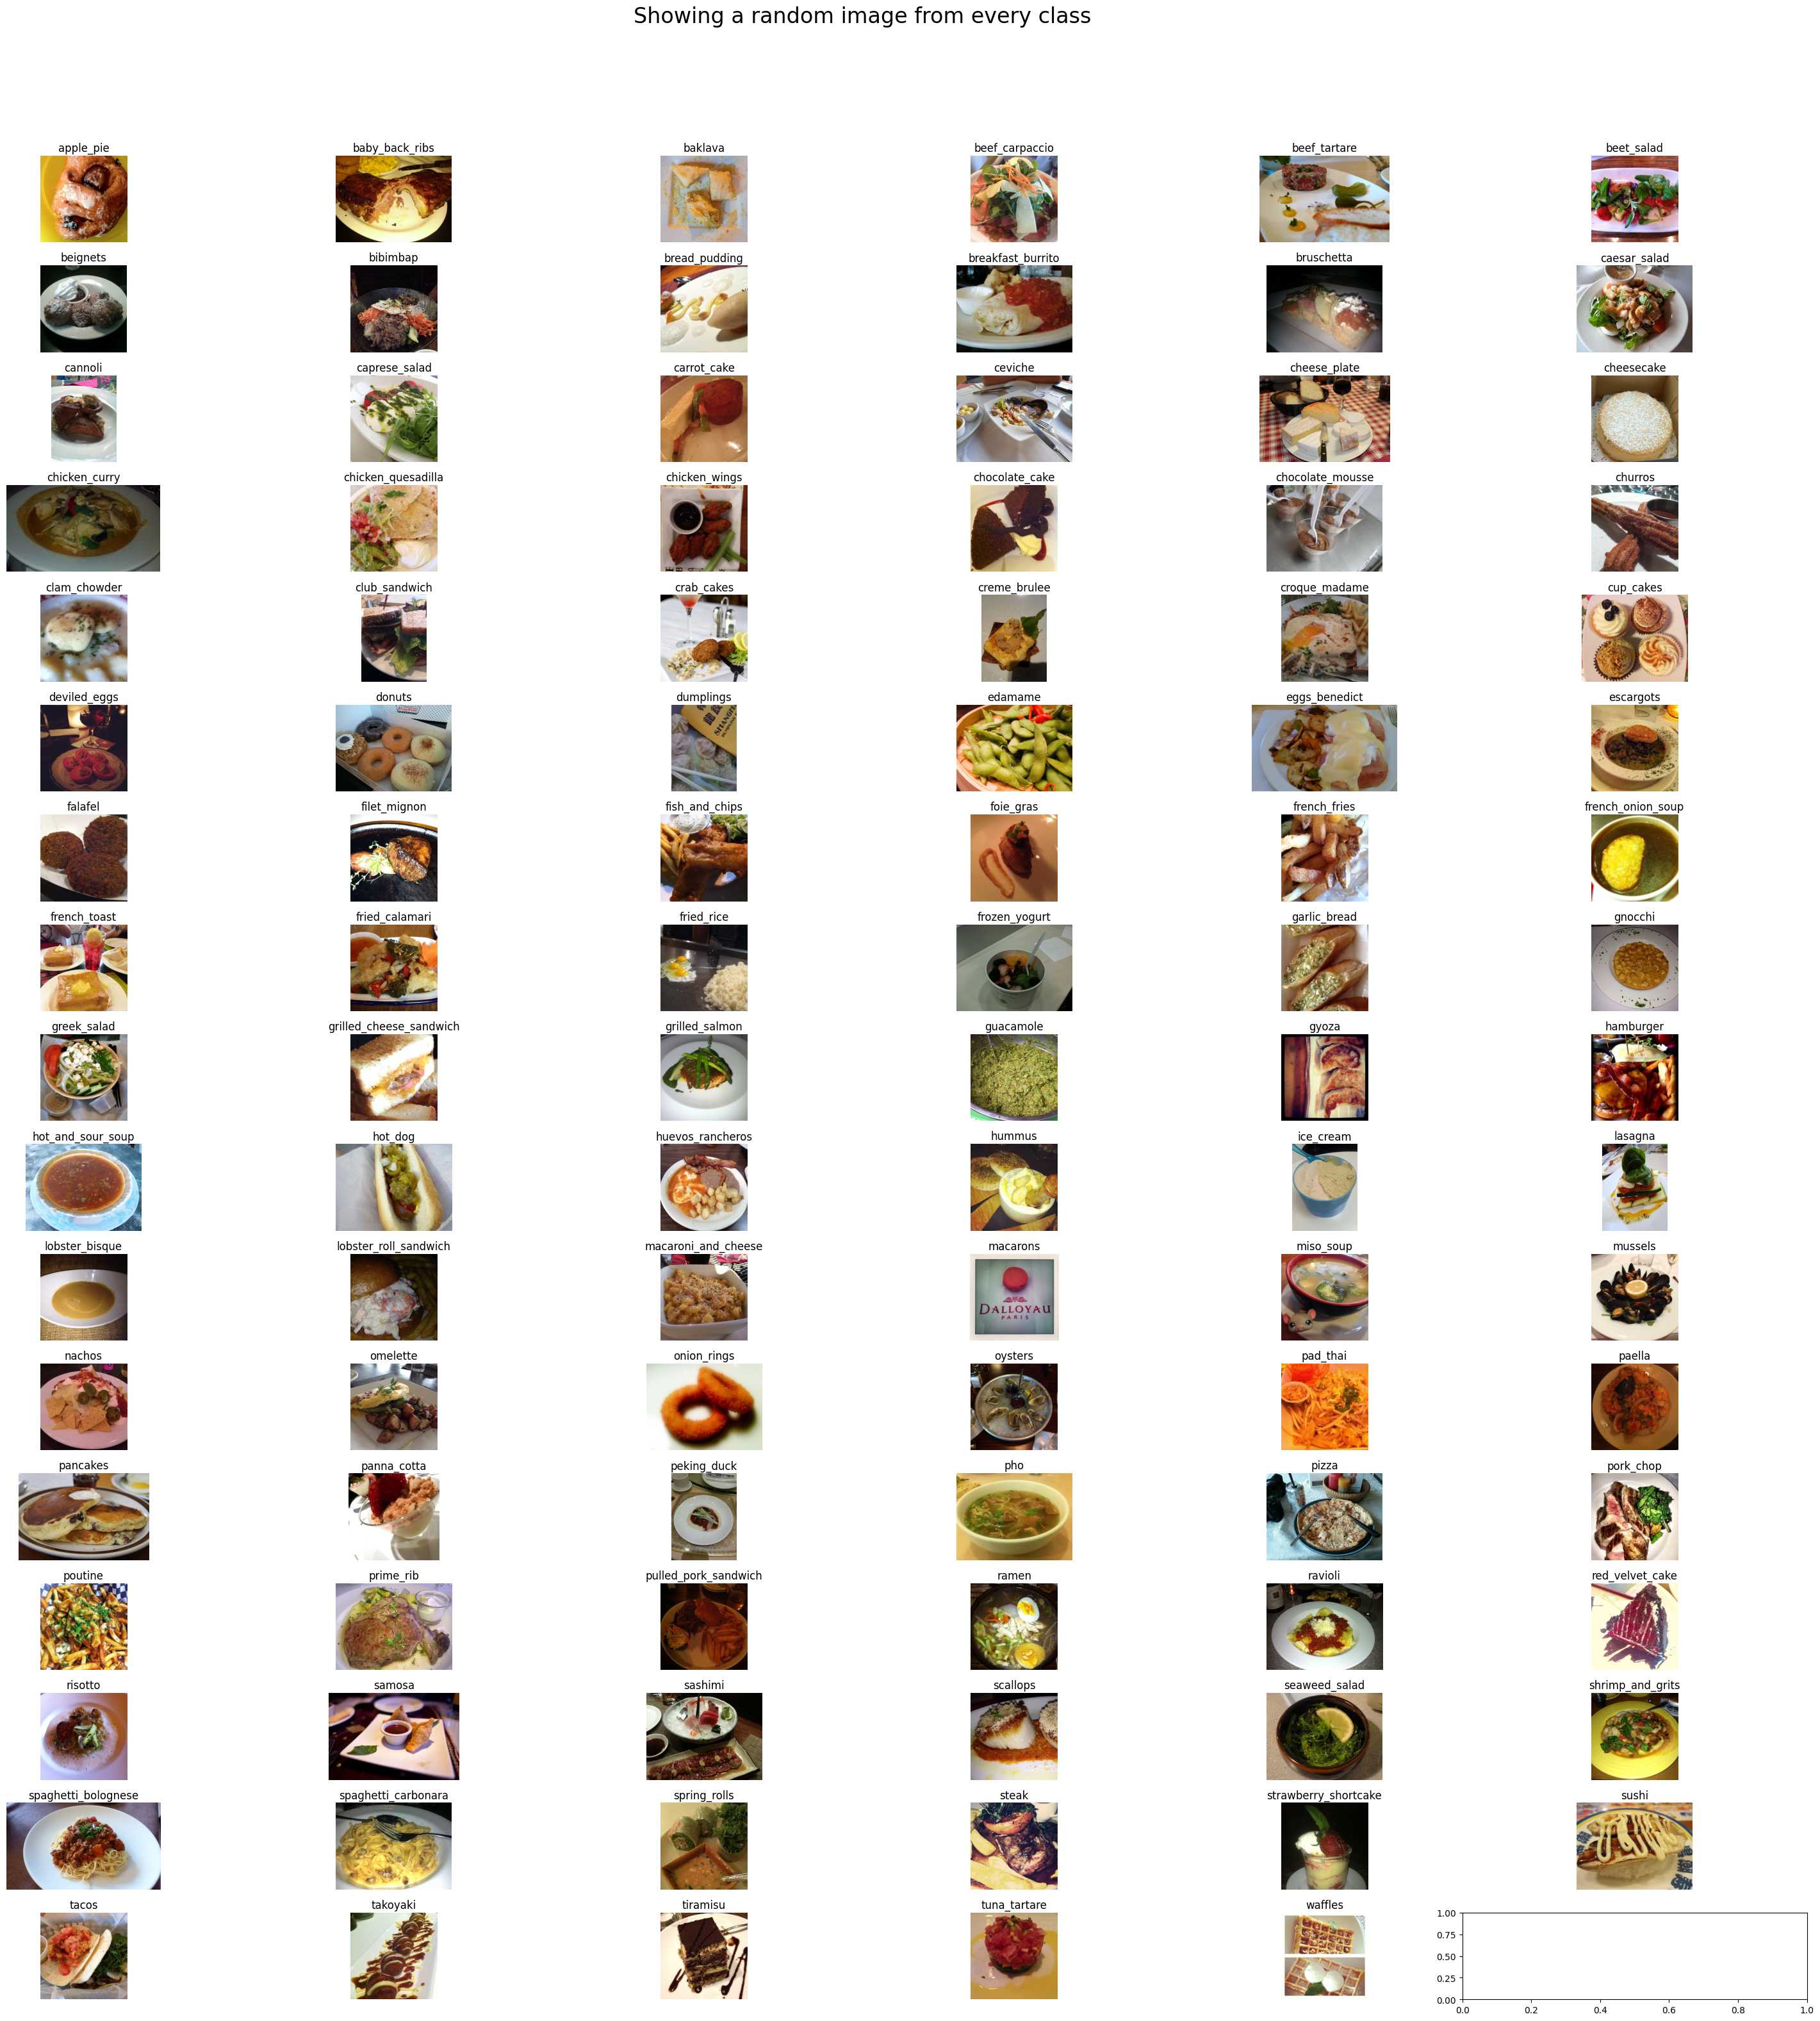

In [12]:
rows, cols = 17, 6
data_dir = "food-101/images/"

# Set up the plot
fig, ax = plt.subplots(rows, cols, figsize=(30, 30))
fig.suptitle("Showing a random image from every class", y=1.05, fontsize=24)

# Get sorted list of food classes
foods_sorted = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

# Iterate over the grid and plot one image per class
for idx, food in enumerate(foods_sorted[:rows*cols]):
    i, j = divmod(idx, cols)
    food_images = os.listdir(os.path.join(data_dir, food))
    random_image = np.random.choice(food_images)
    img = plt.imread(os.path.join(data_dir, food, random_image))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food, pad=5)
    ax[i][j].axis('off')  # Remove axes ticks

plt.tight_layout()
plt.show()

## Preparing the Training and Testing Datasets

Making a function to copy images from source location to destination location using the meta text file

In [13]:
def prepare_data(filepath, src, dest):
    # Read the file and group images by class
    with open(filepath, 'r') as txt:
        classes_images = defaultdict(list)
        for line in txt:
            food, image = line.strip().split('/')
            classes_images[food].append(image + '.jpg')

    # Copy images to the destination directory
    for food, images in classes_images.items():
        dest_dir = os.path.join(dest, food)
        os.makedirs(dest_dir, exist_ok=True)
        print(f"\nCopying images into {food}")
        for image in images:
            copy(os.path.join(src, food, image), os.path.join(dest, food, image))

    print("Copying Done!")

Making Training Directory and copying images

In [15]:
print("Preparing Training dataset")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')

Creating train data...

Copying images into apple_pie

Copying images into baby_back_ribs

Copying images into baklava

Copying images into beef_carpaccio

Copying images into beef_tartare

Copying images into beet_salad

Copying images into beignets

Copying images into bibimbap

Copying images into bread_pudding

Copying images into breakfast_burrito

Copying images into bruschetta

Copying images into caesar_salad

Copying images into cannoli

Copying images into caprese_salad

Copying images into carrot_cake

Copying images into ceviche

Copying images into cheesecake

Copying images into cheese_plate

Copying images into chicken_curry

Copying images into chicken_quesadilla

Copying images into chicken_wings

Copying images into chocolate_cake

Copying images into chocolate_mousse

Copying images into churros

Copying images into clam_chowder

Copying images into club_sandwich

Copying images into crab_cakes

Copying images into creme_brulee

Copying images into croque_madame

Cop

Making Testing Directory and copying images

In [16]:
print("Preparing Testing Dataset")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Preparing Testing Dataset

Copying images into apple_pie

Copying images into baby_back_ribs

Copying images into baklava

Copying images into beef_carpaccio

Copying images into beef_tartare

Copying images into beet_salad

Copying images into beignets

Copying images into bibimbap

Copying images into bread_pudding

Copying images into breakfast_burrito

Copying images into bruschetta

Copying images into caesar_salad

Copying images into cannoli

Copying images into caprese_salad

Copying images into carrot_cake

Copying images into ceviche

Copying images into cheesecake

Copying images into cheese_plate

Copying images into chicken_curry

Copying images into chicken_quesadilla

Copying images into chicken_wings

Copying images into chocolate_cake

Copying images into chocolate_mousse

Copying images into churros

Copying images into clam_chowder

Copying images into club_sandwich

Copying images into crab_cakes

Copying images into creme_brulee

Copying images into croque_madame



Creating a function to count files in a directory

In [17]:
def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

Counting Training Images

In [19]:
training_images = count_files('/content/train')
print(f"Training Images are {training_images}")

Training Images are 75750


Counting Testing Images

In [20]:
testing_images = count_files('/content/test')
print(f"Testing Images are {testing_images}")

Testing Images are 25250


Making a sorted list of all food items

In [29]:
data_dir = '/content/food-101/images'

foods = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
foods.sort()

#del foods[0] # deleting .DS_STORE file
print(foods)
print(len(foods))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou